In [1]:
from models.snu_net import SNU_Net

import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score

In [2]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"

E_neural_file = "Espikes_neural.npy"
I_neural_file = "Ispikes_neural.npy"
V_file = "V_diff.npy"
C_syn_e_file = "handsub5_C_syn_e.npy"
C_syn_i_file = "handsub5_C_syn_i.npy"
C_den_file = "handsub5_C_den.npy"

E_neural = np.load(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = np.load(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)
C_syn_e = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_syn_e_file)
C_syn_i = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_syn_i_file)
C_den = np.load(base_dir+cell_type+"_"+experiment+"/data/"+C_den_file)

E_neural = torch.from_numpy(E_neural)
I_neural = torch.from_numpy(I_neural)
C_syn_e = torch.from_numpy(C_syn_e)
C_syn_i = torch.from_numpy(C_syn_i)
V = torch.from_numpy(V)
C_den = torch.from_numpy(C_den)
sub_no = C_den.shape[0]

#####
V[V < 0.3] = 0

In [3]:
T_train = 8 * 1000 * 50
T_test = 1 * 1000 * 50
save_dir = base_dir+cell_type+"_"+experiment+"/"
device = torch.device("cuda")

batch_size = 1000
iter_no = 10000
epoch_no = iter_no*batch_size//T_train 

weight_init = 0
decay_init = 0.75
threshold_init = 0.25
prop_init = 1

In [4]:
V_train = V[:T_train].float()
V_test = V[T_train:T_train + T_test].to(device).float()
test_E_neural = E_neural[T_train:T_train+T_test].float().to(device)
test_I_neural = I_neural[T_train:T_train+T_test].float().to(device)
train_E_neural = E_neural[:T_train].float()
train_I_neural = I_neural[:T_train].float()
C_syn_e = C_syn_e.float().to(device)
C_syn_i = C_syn_i.float().to(device)
C_den = C_den.float().to(device)

###
part_V_train = V_train[:50000].to(device)
part_train_E_neural = train_E_neural[:50000].to(device)
part_train_I_neural = train_I_neural[:50000].to(device)
###


batch_no = (T_train - batch_size) * epoch_no
train_idx = np.empty((epoch_no, T_train//batch_size))
for i in range(epoch_no):
    #part_idx = np.arange(T_train - batch_size)
    part_idx = np.arange(0, T_train, batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

In [5]:
model = SNU_Net(C_den, C_syn_e, C_syn_i,
                 weight_init, decay_init, threshold_init, prop_init,
                 device)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

25


In [6]:
for i in tnrange(iter_no):
    model.train()
    optimizer.zero_grad()
        
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_size].to(device)
    batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_size].to(device)
    batch_V = V_train[batch_idx : batch_idx+batch_size].to(device)
    
    V_pred, spk_pred = model(batch_E_neural, batch_I_neural)
        
    loss = torch.mean((V_pred - batch_V)**2)
    #loss = torch.var(V_pred - batch_V)
    
    loss.backward()
    optimizer.step()
    
    if i%100 == 99:
        model.eval()
        test_V_pred, test_spk_pred = model(test_E_neural, test_I_neural) 
        train_V_pred, train_spk_pred = model(part_train_E_neural, part_train_I_neural) 
         
        test_mse = torch.mean((test_V_pred - V_test)**2).item()
        test_var = explained_variance_score(V_test.cpu().detach().numpy(), test_V_pred.cpu().detach().numpy())
        train_mse = torch.mean((train_V_pred - part_V_train)**2).item()
        train_var = explained_variance_score(part_V_train.cpu().detach().numpy(), train_V_pred.cpu().detach().numpy())
        
        print(i, np.round(test_var, 6),
              np.round(test_mse, 6),
              torch.sum(test_spk_pred).item(),
              np.round(torch.mean(model.decay_raw).item(), 6),
              np.round(torch.mean(model.threshold_raw).item() , 6),
              np.round(torch.mean(model.weight_raw).item() , 6),
              np.round(torch.mean(model.prop_raw).item() , 6)
             )


<ipython-input-6-d5de07ccc3e3>:1: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


99 -1.189367 0.047239 293.0 0.740757 0.254915 0.000837 0.986847
199 -1.071676 0.044661 288.0 0.731303 0.271164 0.003975 0.970026
299 -1.052712 0.044244 287.0 0.719198 0.291923 0.004261 0.950791
399 -0.9809 0.042642 281.0 0.699402 0.336347 0.00457 0.918466
499 -0.706567 0.036567 254.0 0.682809 0.379893 0.001958 0.886683
599 -0.68182 0.036028 252.0 0.678124 0.383454 0.003062 0.875132
699 -0.559914 0.033384 242.0 0.673344 0.383043 0.003822 0.859391
799 -0.559914 0.033384 242.0 0.672489 0.379643 0.005465 0.850139
899 -0.559914 0.033384 242.0 0.66958 0.37577 0.00919 0.839449
999 -0.550465 0.033177 240.0 0.66485 0.378623 0.009465 0.821823
1099 -0.542496 0.033005 239.0 0.661807 0.37999 0.009693 0.811819
1199 -0.542496 0.033005 239.0 0.659227 0.370988 0.009007 0.804447
1299 -0.542496 0.033005 239.0 0.653185 0.381969 0.007942 0.790752
1399 -0.542496 0.033005 239.0 0.650513 0.382478 0.007328 0.780624
1499 -0.534988 0.032842 238.0 0.648294 0.373969 0.007776 0.768018
1599 -0.534988 0.032842 238.0 

KeyboardInterrupt: 

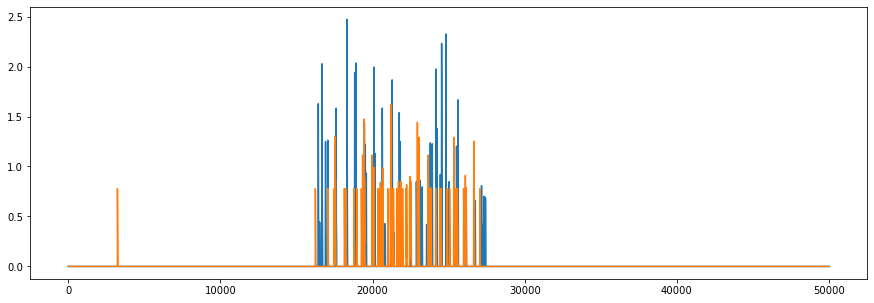

In [7]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy())
plt.plot(test_V_pred.cpu().detach().numpy())


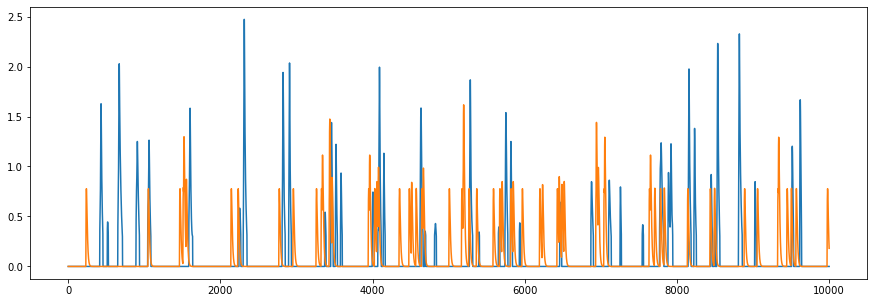

In [8]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[16000:26000])
plt.plot(test_V_pred.cpu().detach().numpy()[16000:26000])


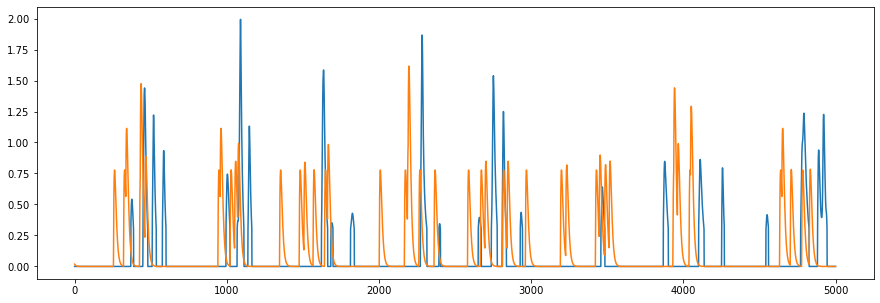

In [9]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[16000:26000][3000:8000])
plt.plot(test_V_pred.cpu().detach().numpy()[16000:26000][3000:8000])


In [10]:
print(model.threshold_raw)

Parameter containing:
tensor([0.4275, 0.3272, 0.3294, 0.3460, 0.3449], device='cuda:0',
       requires_grad=True)
